<a href="https://colab.research.google.com/github/f247805/ABSA-Analysis-with-Explainability-Methods/blob/main/paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install transformers
!pip install jsonlines
#!pip install torch

In [ ]:

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support


from google.colab import files

uploaded = files.upload()  # This will open a file upload dialog

sentences = []
aspect_polarities = []

with jsonlines.open("/content/FINAL_CLEANED_CORRECTED_SHUFFLED_DATASET_NO_DUPLICATE.jsonl") as reader:
    for line in reader:
        text = line['text']
        sentences.append(text)

        labels = line['labels']
        aspects = [label['aspect'] for label in labels]
        polarities = [label['polarity'] for label in labels]

        aspect_polarities.append({'aspects': aspects, 'polarities': polarities})

# Split the data into training, validation, and test sets
sentences_train, sentences_remaining, aspect_polarities_train, aspect_polarities_remaining = train_test_split(
    sentences, aspect_polarities, test_size=0.3, random_state=42
)
sentences_val, sentences_test, aspect_polarities_val, aspect_polarities_test = train_test_split(
    sentences_remaining, aspect_polarities_remaining, test_size=0.5, random_state=42
)



Saving FINAL_CLEANED_CORRECTED_SHUFFLED_DATASET_NO_DUPLICATE.jsonl to FINAL_CLEANED_CORRECTED_SHUFFLED_DATASET_NO_DUPLICATE.jsonl


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Batch 8/2700 - Loss: 1.1047
Batch 16/2700 - Loss: 1.1039
Batch 24/2700 - Loss: 1.0917
Batch 32/2700 - Loss: 1.0808
Batch 40/2700 - Loss: 1.0716
Batch 48/2700 - Loss: 1.0690
Batch 56/2700 - Loss: 1.0542
Batch 64/2700 - Loss: 1.0375
Batch 72/2700 - Loss: 1.0382
Batch 80/2700 - Loss: 1.0302
Batch 88/2700 - Loss: 1.0271
Batch 96/2700 - Loss: 1.0214
Batch 104/2700 - Loss: 1.0118
Batch 112/2700 - Loss: 1.0071
Batch 120/2700 - Loss: 0.9999
Batch 128/2700 - Loss: 0.9915
Batch 136/2700 - Loss: 0.9794
Batch 144/2700 - Loss: 0.9755
Batch 152/2700 - Loss: 0.9666
Batch 160/2700 - Loss: 0.9538
Batch 168/2700 - Loss: 0.9530
Batch 176/2700 - Loss: 0.9438
Batch 184/2700 - Loss: 0.9356
Batch 192/2700 - Loss: 0.9263
Batch 200/2700 - Loss: 0.9153
Batch 208/2700 - Loss: 0.9141
Batch 216/2700 - Loss: 0.9044
Batch 224/2700 - Loss: 0.8958
Batch 232/2700 - Loss: 0.8903
Batch 240/2700 - Loss: 0.8855
Batch 248/2700 - Loss: 0.8831
Batch 256/2700 - Loss: 0.8756
Batch 264/2700 - Loss: 0.8754
Batch 272/27

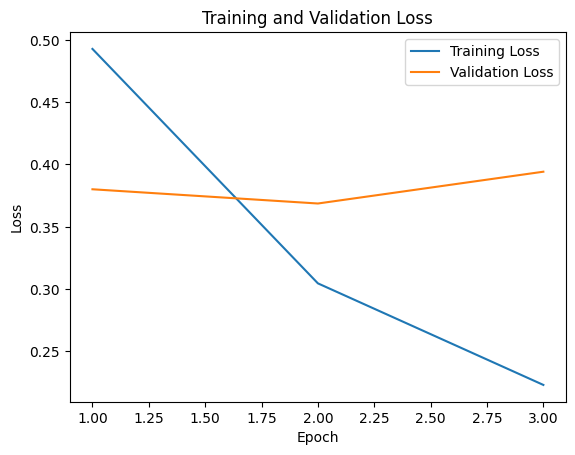

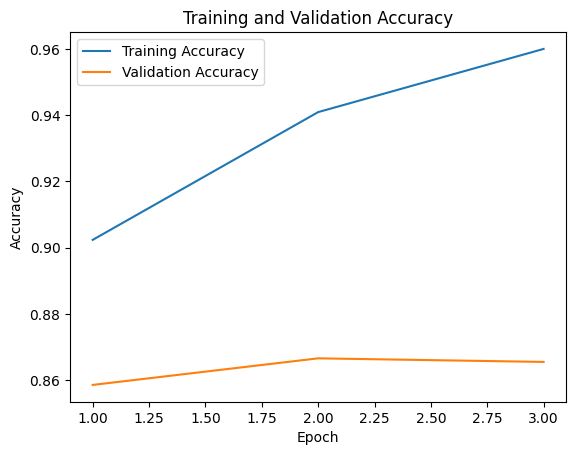

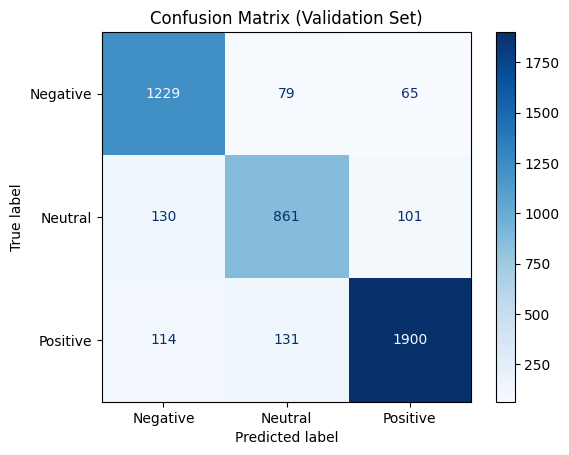

Accuracy on test set: 88.58%
Macro Metrics:
  Precision: 0.8730
  Recall: 0.8767
  F1 Score: 0.8746


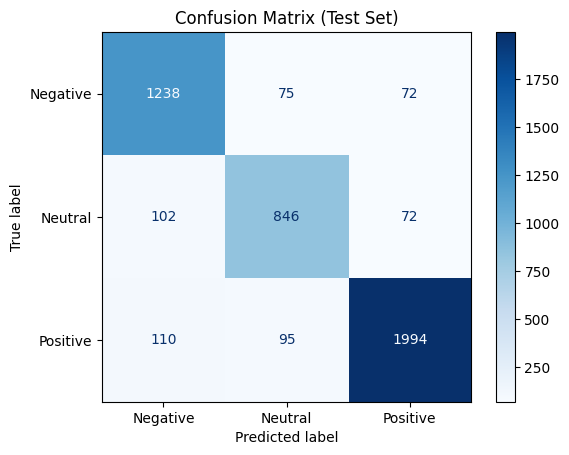

Mounted at /content/drive
Model and tokenizer saved to /content/drive/MyDrive/saved_model_roberta_check1/


In [ ]:
# Initialize the tokenizer and the model

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Prepare tokenized data and labels for training
tokenized_data_train = []
labels_train = []

for text, aspect_polarity in zip(sentences_train, aspect_polarities_train):
    aspects = aspect_polarity['aspects']
    polarities = aspect_polarity['polarities']

    for aspect, polarity in zip(aspects, polarities):
        input_text = f"{text} </s></s> {aspect}"
        tokenized_text = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        tokenized_data_train.append(tokenized_text)

        label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        label = label_map[polarity]
        labels_train.append(label)

# Convert labels to tensor
labels_train = torch.tensor(labels_train)

# Create TensorDataset and DataLoader for training
dataset_train = TensorDataset(
    pad_sequence([x.input_ids.squeeze(0) for x in tokenized_data_train], batch_first=True),
    pad_sequence([x.attention_mask.squeeze(0) for x in tokenized_data_train], batch_first=True),
    labels_train
)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

# Prepare tokenized data and labels for validation
tokenized_data_val = []
labels_val = []

for text, aspect_polarity in zip(sentences_val, aspect_polarities_val):
    aspects = aspect_polarity['aspects']
    polarities = aspect_polarity['polarities']

    for aspect, polarity in zip(aspects, polarities):
        input_text = f"{text} </s></s> {aspect}"
        tokenized_text = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        tokenized_data_val.append(tokenized_text)

        label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        label = label_map[polarity]
        labels_val.append(label)

# Convert labels to tensor for validation
labels_val = torch.tensor(labels_val)

# Create TensorDataset and DataLoader for validation
dataset_val = TensorDataset(
    pad_sequence([x.input_ids.squeeze(0) for x in tokenized_data_val], batch_first=True),
    pad_sequence([x.attention_mask.squeeze(0) for x in tokenized_data_val], batch_first=True),
    labels_val
)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

# Prepare tokenized data and labels for test
tokenized_data_test = []
labels_test = []

for text, aspect_polarity in zip(sentences_test, aspect_polarities_test):
    aspects = aspect_polarity['aspects']
    polarities = aspect_polarity['polarities']

    for aspect, polarity in zip(aspects, polarities):
        input_text = f"{text} </s></s> {aspect}"
        tokenized_text = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
        tokenized_data_test.append(tokenized_text)

        label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        label = label_map[polarity]
        labels_test.append(label)

# Convert labels to tensor for test
labels_test = torch.tensor(labels_test)

# Create TensorDataset and DataLoader for test
dataset_test = TensorDataset(
    pad_sequence([x.input_ids.squeeze(0) for x in tokenized_data_test], batch_first=True),
    pad_sequence([x.attention_mask.squeeze(0) for x in tokenized_data_test], batch_first=True),
    labels_test
)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)


# Function to generate confusion matrix
def generate_confusion_matrix(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, batch_labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)

            true_labels.extend(batch_labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    return conf_matrix


# Initialize lists to store losses and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Fine-tune the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0.0
    total_batches = 0

    for batch_num, batch in enumerate(dataloader_train, 1):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, batch_labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

        if batch_num % 8 == 0:
            avg_loss = total_loss / total_batches
            print(f"Batch {batch_num}/{len(dataloader_train)} - Loss: {avg_loss:.4f}")

    avg_epoch_loss = total_loss / total_batches
    train_losses.append(avg_epoch_loss)
    print(f"\nAverage Training Loss for Epoch {epoch + 1}: {avg_epoch_loss:.4f}")

    # Calculate training accuracy
    model.eval()
    total_correct_preds_train = 0
    total_preds_train = 0
    with torch.no_grad():
        for batch in dataloader_train:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, batch_labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)

            total_preds_train += batch_labels.size(0)
            total_correct_preds_train += (predicted == batch_labels).sum().item()

    accuracy_train = total_correct_preds_train / total_preds_train if total_preds_train > 0 else 0
    train_accuracies.append(accuracy_train)
    print(f"Training Accuracy for Epoch {epoch + 1}: {accuracy_train * 100:.2f}%")

    # Validation part
    model.eval()
    total_correct_preds_val = 0
    total_preds_val = 0
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in dataloader_val:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, batch_labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=batch_labels)
            _, predicted = torch.max(outputs.logits, 1)

            total_preds_val += batch_labels.size(0)
            total_correct_preds_val += (predicted == batch_labels).sum().item()

            total_val_loss += outputs.loss.item()

    accuracy_val = total_correct_preds_val / total_preds_val if total_preds_val > 0 else 0
    avg_val_loss = total_val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy_val)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy_val * 100:.2f}%")

# Plot training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Confusion matrix for validation set
conf_matrix_val = generate_confusion_matrix(model, dataloader_val)

classes = ['Negative', 'Neutral', 'Positive']


# Plot confusion matrix for validation set
disp = ConfusionMatrixDisplay(conf_matrix_val, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Validation Set)')
plt.show()


# Evaluation on test set
model.eval()
total_correct_preds_test = 0
total_preds_test = 0
true_labels_test = []
predicted_labels_test = []

with torch.no_grad():
    for batch in dataloader_test:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, batch_labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)

        true_labels_test.extend(batch_labels.cpu().numpy())
        predicted_labels_test.extend(predicted.cpu().numpy())

        total_preds_test += batch_labels.size(0)
        total_correct_preds_test += (predicted == batch_labels).sum().item()

accuracy_test = total_correct_preds_test / total_preds_test if total_preds_test > 0 else 0
print(f"Accuracy on test set: {accuracy_test * 100:.2f}%")

# Compute confusion matrix for test set
conf_matrix_test = generate_confusion_matrix(model, dataloader_test)

# Compute precision, recall, F1 score and support (count of true instances) for each class and their averages
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels_test, predicted_labels_test, average='macro')

# Print macro precision, recall, F1 score
print("Macro Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1_score:.4f}")

# Plot confusion matrix for test set
disp = ConfusionMatrixDisplay(conf_matrix_test, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.show()


# # Save the model and tokenizer
# model.save_pretrained('distilbert-base-uncased_fine_tuned_aspect_sentiment_model_lr_1e-5_bs_8_epoch_6_plots')
# tokenizer.save_pretrained('tokenizer_distilbert-base-uncased_fine_tuned_aspect_sentiment_model_lr_1e-5_bs_8_epoch_6_plots')
from google.colab import drive
drive.mount('/content/drive')
# Save the model and tokenizer
model.save_pretrained('FINE_TUNED_MODEL_roberta-base_model_lr_3e-6_bs_64_epoch_15_plots')
tokenizer.save_pretrained('tokenizer_roberta-base_lr_3e-6_bs_64_epoch_15_plots')
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Define save paths (adjust as needed)
SAVE_PATH = "/content/drive/MyDrive/saved_model_roberta_check1/"  # Google Drive path
# SAVE_PATH = "./my_model/"  # Local Colab path

# Save model and tokenizer
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print(f"Model and tokenizer saved to {SAVE_PATH}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shap
import torch
from transformers import RobertaTokenizer

def predict_aspect(texts, aspect="food"):
    """
    Returns model probabilities for texts combined with a fixed aspect.
    """
    # Combine text and aspect using the same separator as in training
    combined_texts = [f"{text} </s></s> {aspect}" for text in texts]  # Match training separator

    # Tokenize
    inputs = tokenizer(
        combined_texts,
        padding=True,
        truncation=True,
        max_length=128,  # Match training max_length
        return_tensors="pt"
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probabilities

In [ ]:
# Target text and aspect
text_to_explain = "The food at the restaurant was amazing, but the service was terrible."
aspect = "food"  # Aspect to analyze

# Wrap prediction function to fix the aspect
def predict(texts):
    return predict_aspect(texts, aspect=aspect)

# Initialize SHAP explainer
explainer = shap.Explainer(
    predict,
    masker= shap.maskers.Text(tokenizer),  # Perturb words in the text (not the aspect)
    output_names=["negative", "neutral", "positive"]
)

# Compute SHAP values
shap_values = explainer([text_to_explain])

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch
model_path = "/content/drive/MyDrive/saved_model_roberta_check1/"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set evaluation mode

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
pip install shap==0.46.0  # Use a known-stable version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.44.0
    Uninstalling shap-0.44.0:
      Successfully uninstalled shap-0.44.0


In [ ]:
import shap
import torch
import numpy as np
import random
from transformers import RobertaTokenizer
from IPython.display import HTML, display


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
model.eval()  # Disable dropout

# Define prediction function
def predict_aspect(texts, aspect="food"):
    combined_texts = [f"{text} </s></s> {aspect}" for text in texts]
    inputs = tokenizer(
        combined_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)  # Change to device instead of "cpu"
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

# Define `predict` function (required by SHAP)
aspect = "food"  # Define the aspect here
def predict(texts):
    return predict_aspect(texts, aspect=aspect)  # Pass the fixed aspect

# Initialize SHAP explainer
explainer = shap.Explainer(
    predict,  # Now defined
    masker=shap.maskers.Text(tokenizer),
    output_names=["negative", "neutral", "positive"],
    seed=seed
)

# Compute SHAP values
text_to_explain = "The food at the restaurant was amazing, but the service was terrible."
shap_values = explainer([text_to_explain])

# Generate and display the plot
shap.plots.text(shap_values)

Grad-CAM Relevance Scores for Aspect 'food' in Input Text:
<s>: 1.0000
The: 0.8197
Ġfood: 0.8431
Ġat: 0.4159
Ġthe: 0.3502
Ġrestaurant: 0.4931
Ġwas: 0.7912
Ġamazing: 0.8339
,: 0.4454
Ġbut: 0.4249
Ġthe: 0.0000
Ġservice: 0.0000
Ġwas: 0.0000
Ġterrible: 0.0000
.: 0.9675
Ġ: 0.8362
</s>: 0.8034
</s>: 0.7784
Ġfood: 0.8285
</s>: 0.7614

Predicted Polarity for Aspect 'food': positive


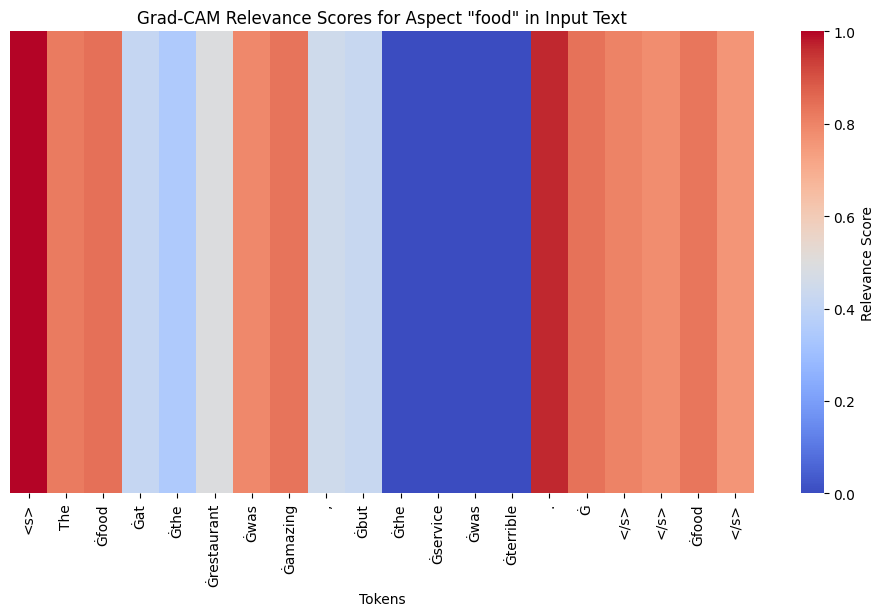

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns


class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)


    def save_activations(self, module, input, output):
        # Handle the tuple case for XLNet
        if isinstance(output, tuple):
            self.activations = output[0]
        else:
            self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def compute_gradcam(self, input_text, aspect, tokenizer):
        combined_input = f"{input_text} </s></s> {aspect}"
        inputs = tokenizer(combined_input, return_tensors='pt')

        # Move inputs to the same device as the model
        device = next(self.model.parameters()).device
        inputs = {key: val.to(device) for key, val in inputs.items()}

        self.model.eval()
        outputs = self.model(**inputs)

        target_class = torch.argmax(outputs.logits, dim=1).item()
        target_score = outputs.logits[0, target_class]

        self.model.zero_grad()
        target_score.backward()

        gradients = self.gradients.mean(dim=1).squeeze()
        activations = self.activations.squeeze()

        weights = gradients
        cam = torch.zeros(activations.size(0), device=device)  # Ensure same device

        for i in range(activations.size(0)):
            cam[i] = (weights * activations[i]).sum()

        cam = torch.relu(cam)
        cam = cam / cam.max()

        return cam.cpu(), inputs['input_ids'][0].cpu(), target_class  # Move to CPU for visualization



# Example
input_text = "The food at the restaurant was amazing, but the service was terrible."
aspect = "food"

# input_text = "Excellent location and friendly staff, but disappointing room cleanliness. Breakfast was adequate."
# aspect = "room cleanliness"



target_layer = model.roberta.encoder.layer[-1].output

# Initialize Grad-CAM
gradcam = GradCam(model, target_layer)

# Compute Grad-CAM scores for the aspect
cam_scores, input_ids, target_class = gradcam.compute_gradcam(input_text, aspect, tokenizer)

# Convert token IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Combine tokens with their corresponding Grad-CAM scores
highlighted_text = [(token, score.item()) for token, score in zip(tokens, cam_scores)]

# Print the tokens with their relevance scores
print(f"Grad-CAM Relevance Scores for Aspect '{aspect}' in Input Text:")
for token, score in highlighted_text:
    print(f"{token}: {score:.4f}")

# Define a mapping from class index to sentiment polarity
polarity_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_polarity = polarity_mapping.get(target_class, 'unknown')

# Print the predicted polarity
print(f"\nPredicted Polarity for Aspect '{aspect}': {predicted_polarity}")

# Visualize the results in a heatmap without annotations
plt.figure(figsize=(12, 6))
ax = sns.heatmap([cam_scores.detach().numpy()], cmap='coolwarm', cbar_kws={'label': 'Relevance Score'})

ax.set_title(f'Grad-CAM Relevance Scores for Aspect "{aspect}" in Input Text')
ax.set_xlabel('Tokens')
ax.set_xticklabels(tokens, rotation=90)  # Rotate words to be vertical
plt.yticks([], [])  # Hide y-axis labels

# Show the plot
plt.show()

In [ ]:
model.eval()  # Set to evaluation mode

# Select the last layer of the encoder for Grad-CAM
target_layer = model.roberta.encoder.layer[-1].output

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns


def compute_gradcam(self, input_text, aspect, tokenizer):
    combined_input = f"{input_text} </s></s> {aspect}"
    inputs = tokenizer(combined_input, return_tensors='pt')

    # Move inputs to the same device as the model
    device = next(self.model.parameters()).device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    self.model.eval()
    outputs = self.model(**inputs)

    target_class = torch.argmax(outputs.logits, dim=1).item()
    target_score = outputs.logits[0, target_class]

    self.model.zero_grad()
    target_score.backward()

    gradients = self.gradients.mean(dim=1).squeeze()
    activations = self.activations.squeeze()

    weights = gradients
    cam = torch.zeros(activations.size(0), device=device)  # Ensure cam is on the same device

    for i in range(activations.size(0)):
        cam[i] = (weights * activations[i]).sum()

    cam = torch.relu(cam)
    cam = cam / cam.max()

    return cam.cpu(), inputs['input_ids'][0].cpu(), target_class  # Move to CPU for visualization


# Example
input_text = "The food at the restaurant was amazing, but the service was terrible."
aspect = "food"

# input_text = "Excellent location and friendly staff, but disappointing room cleanliness. Breakfast was adequate."
# aspect = "room cleanliness"


# Model and tokenizer selection
model_files = {
    'roberta': ('FINE_TUNED_MODEL_roberta-base_model_lr_1e-5_bs_8_epoch_15_plots_89.16%', 'roberta-base'),

}

model_type = 'roberta'



# Select the last layer of the encoder based on model type
if model_type == 'roberta':
    target_layer = model.roberta.encoder.layer[-1].output


# Initialize Grad-CAM
gradcam = GradCam(model, target_layer)

# Compute Grad-CAM scores for the aspect
cam_scores, input_ids, target_class = gradcam.compute_gradcam(input_text, aspect, tokenizer)

# Convert token IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Combine tokens with their corresponding Grad-CAM scores
highlighted_text = [(token, score.item()) for token, score in zip(tokens, cam_scores)]

# Print the tokens with their relevance scores
print(f"Grad-CAM Relevance Scores for Aspect '{aspect}' in Input Text:")
for token, score in highlighted_text:
    print(f"{token}: {score:.4f}")

# Define a mapping from class index to sentiment polarity
polarity_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_polarity = polarity_mapping.get(target_class, 'unknown')

# Print the predicted polarity
print(f"\nPredicted Polarity for Aspect '{aspect}': {predicted_polarity}")

# Visualize the results in a heatmap without annotations
plt.figure(figsize=(12, 6))
ax = sns.heatmap([cam_scores.detach().numpy()], cmap='coolwarm', cbar_kws={'label': 'Relevance Score'})
ax.set_title(f'Grad-CAM Relevance Scores for Aspect "{aspect}" in Input Text')
ax.set_xlabel('Tokens')
ax.set_xticklabels(tokens, rotation=90)  # Rotate words to be vertical
plt.yticks([], [])  # Hide y-axis labels

# Show the plot
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)